<a href="https://colab.research.google.com/github/tsbhun98/Szamitasi_Intelligencia_GTSRB/blob/main/GTSRB_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data=[]
labels=[]

height = 30
width = 30
channels = 3
n_inputs = height * width*channels

#12 - Foutvonal
#13 - Elsobbsegadas kotelezo
#14 - STOP
#15 - Mindket iranybol behajtani tilos

for i in range(12, 16) :
    path = "/content/gdrive/My Drive/GTSRB/Final_Training/{}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i-12)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

s=np.arange(Cells.shape[0])
np.random.seed(4)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

/content/gdrive/My Drive/GTSRB/Final_Training/12/
 
/content/gdrive/My Drive/GTSRB/Final_Training/13/
 
/content/gdrive/My Drive/GTSRB/Final_Training/14/
 
/content/gdrive/My Drive/GTSRB/Final_Training/15/
 


In [ ]:
# Tanitasi es validacios keszlet felosztasa (80-20)
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#one hote encoding hasznalata
y_train = to_categorical(y_train, 4)
y_val = to_categorical(y_val, 4)

In [ ]:
len(X_train)

4536

In [ ]:
print(y_train[0])

[0. 0. 1. 0.]


In [ ]:
#https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
input_shape = X_train.shape[1:] # (30,30,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import time

epochs = 2

start = time.time()

history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

end = time.time()
print("Modell tanítási ideje: {:.2f} s".format(end-start))

Epoch 1/2
142/142 [==============================] - 10s 7ms/step - loss: 0.1558 - accuracy: 0.9528 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 2/2
142/142 [==============================] - 1s 5ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0072 - val_accuracy: 0.9974
Modell tanítási ideje: 10.94 s


In [ ]:
test = pd.read_csv('/content/gdrive/My Drive/GTSRB/GT-final_test.csv', sep=';')

X_test = []
y_test = []
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    if class_id>=12 and class_id<=15:
        path = os.path.join('/content/gdrive/My Drive/GTSRB/Final_Test/', file_name)
        try:
            image=cv2.imread(path)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            X_test.append(np.array(size_image))
            y_test.append(class_id-12)
        except AttributeError:
            print(" ")

y_test = np.array(y_test)        
X_test = np.array(X_test)
X_test = X_test.astype('float32')/255 

pred = np.argmax(model.predict(X_test), axis=-1)

60/60 [==============================] - 0s 3ms/step


In [ ]:
#Pontossag a tesztkeszleten
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print("Pontosság a tesztkészleten: {:.2f} %".format(acc*100))

Pontosság a tesztkészleten: 97.41 %


In [ ]:
%pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 133 kB/s 
     |████████████████████████████████| 154 kB 64.4 MB/s 
     |████████████████████████████████| 41 kB 307 kB/s 


In [ ]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

epsilon = 0.2

from absl import app, flags
FLAGS = flags.FLAGS

start = time.time()

x_fgm = fast_gradient_method(model, X_test, epsilon, np.inf)

end = time.time()
print("Ellenséges példák generálási ideje az FGSM módszerrel: {:.2f} s".format(end-start))

test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()

y_pred_fgm = model(x_fgm)
test_acc_fgsm(y_test, y_pred_fgm)
print('Pontosság az FGSM által generált ellenséges példákon (%): {:.2f}'.format(test_acc_fgsm.result() * 100))

Ellenséges példák generálási ideje az FGSM módszerrel: 1.18 s
Pontosság az FGSM által generált ellenséges példákon (%): 1.96


In [ ]:
#ellenseges peldak generalasa PGD
start = time.time()

x_pgd = projected_gradient_descent(model, X_test, epsilon, 0.01, 40, np.inf)

end = time.time()
print("Ellenséges példák generálási ideje a PGD módszerrel: {:.2f} s".format(end-start))

test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

y_pred_pgd = model(x_pgd)
test_acc_pgd(y_test, y_pred_pgd)
print('Pontosság a PGD által generált ellenséges példákon (%): {:.2f}'.format(test_acc_pgd.result() * 100))

Ellenséges példák generálási ideje a PGD módszerrel: 1.72 s
Pontosság a PGD által generált ellenséges példákon (%): 1.85


In [ ]:
#plottolo fuggveny
import matplotlib.pyplot as plt#0, 2, 6, 11
def plot_images(x, n):
    for i in range(n):
        if i==0 or i==2 or i==6 or i==11:
          print(i)
          plt.axis("off")
          plt.imshow(x[i])
          plt.show()

0


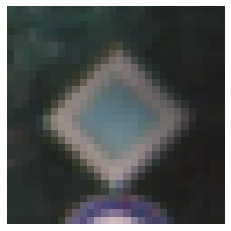

2


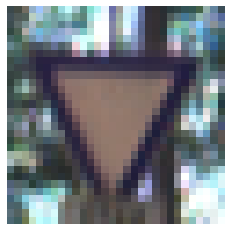

6


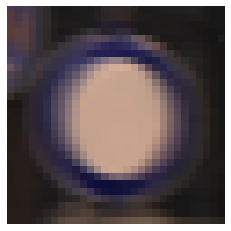

11


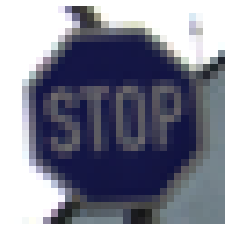

In [ ]:
plot_images(X_test, 20)

0


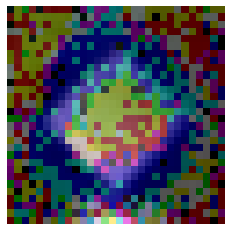

2


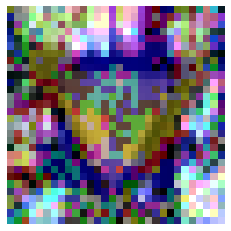

6


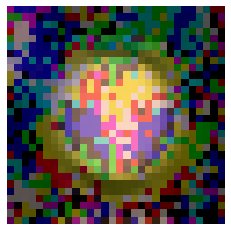

11


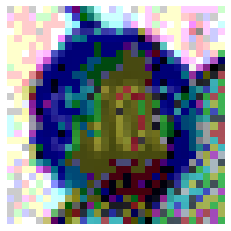

In [ ]:
plot_images(x_fgm, 20)

0


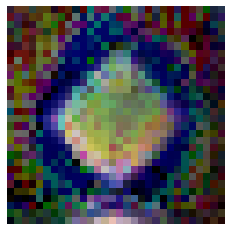

2


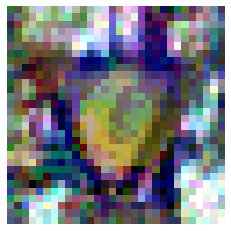

6


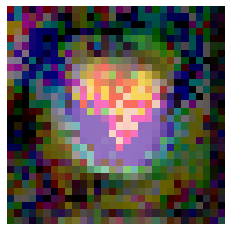

11


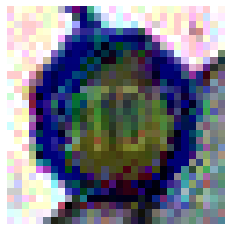

In [ ]:
plot_images(x_pgd,20)